Набор данных Национального института диабета, болезней пищеварительной системы и почек. Цель состоит в том, чтобы на основе диагностических измерений предсказать, есть ли у пациента диабет.

1. Предварительная обработка данных:
— Очистите данные от пропусков (если они есть), обработайте аномалии и нормализуйте данные, если это необходимо.
— Разделите датасет на обучающую и тестовую выборки.

2. Построение модели:
— Используя алгоритм логистической регрессии, постройте модель бинарной классификации для предсказания наличия диабета у пациентов.
— Обучите модель на обучающем наборе данных.

3. Оценка модели:
— Вычислите и проанализируйте метрики точности (accuracy), точности (precision), полноты (recall) и F1-меру для обученной модели на тестовых данных.

In [3]:
import warnings
warnings.filterwarnings('ignore')
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [30]:
!pip install scikit-learn
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv('/content/diabetes-dataset.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


- Pregnancies	- Беременность
- Glucose	- Уровень глюкозы в крови
- BloodPressure - Артериальное давление
- SkinThickness - Толщина кожи
- Insulin	- Инсулин
- BMI	- ИМТ
- DiabetesPedigreeFunction - анамнез диабета (наследственность)
- Age - Возраст
- Outcome - Переменная класса (0 или 1)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


DataFrame содержит 2000 записей (от индекса 0 до 1999).

Всего 9 столбцов в DataFrame, и все они содержат тип данных int64, кроме столбцов BMI, DiabetesPedigreeFunction, которые имеют тип данных float64. Данные не имеют пропущенных значений.

In [6]:
# перепроверим прорущенные значения
df.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [7]:
# выведем уникальные
df.nunique()

,0
Pregnancies,17
Glucose,136
BloodPressure,47
SkinThickness,53
Insulin,182
BMI,247
DiabetesPedigreeFunction,505
Age,52
Outcome,2


<Axes: ylabel='Outcome'>

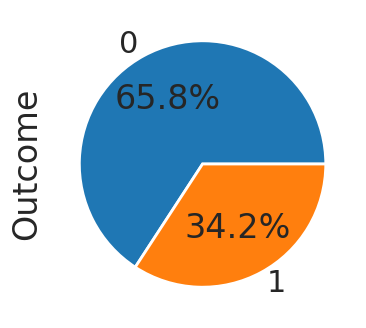

In [8]:
sns.set_style('darkgrid')
sns.set_context('poster')
plt.rcParams['figure.figsize'] = [6,4]
df.groupby('Outcome').size().plot(kind='pie',
                                       y = "Outcome",
                                       label = "Outcome",
                                       autopct='%1.1f%%')

Наблюдаем дисбаланс классов в данных. С долей 65.8% участников, не страдающих диабетом (класс "0"), и 34.2% участников, страдающих диабетом (класс "1"), ясно, что данный набор данных имеет меньшее представительство одного из классов по сравнению с другим.

In [9]:
# убедимся и выведем числовые данные
df.groupby('Outcome').Outcome.value_counts()

,count
Outcome,
0,1316
1,684


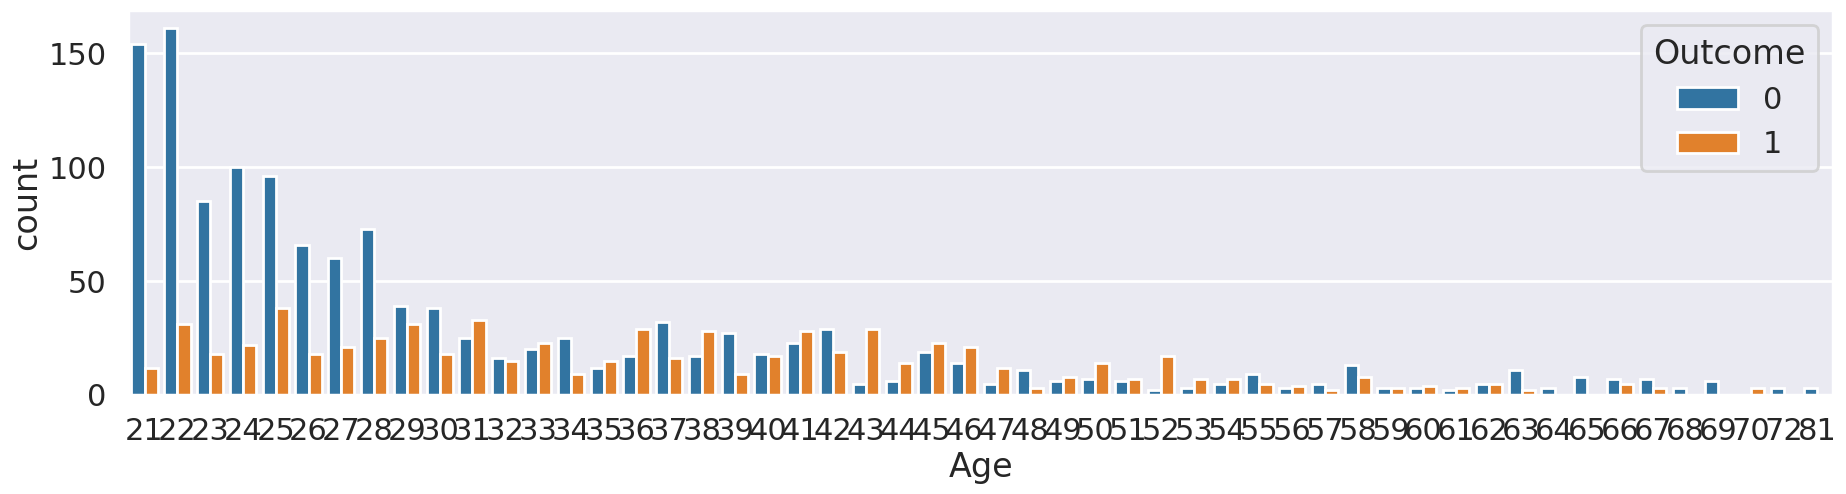

In [10]:
# влияние возраста на заболевание
plt.figure(figsize=(22,5))
sns.countplot(x='Age',hue='Outcome',data=df)
plt.show()

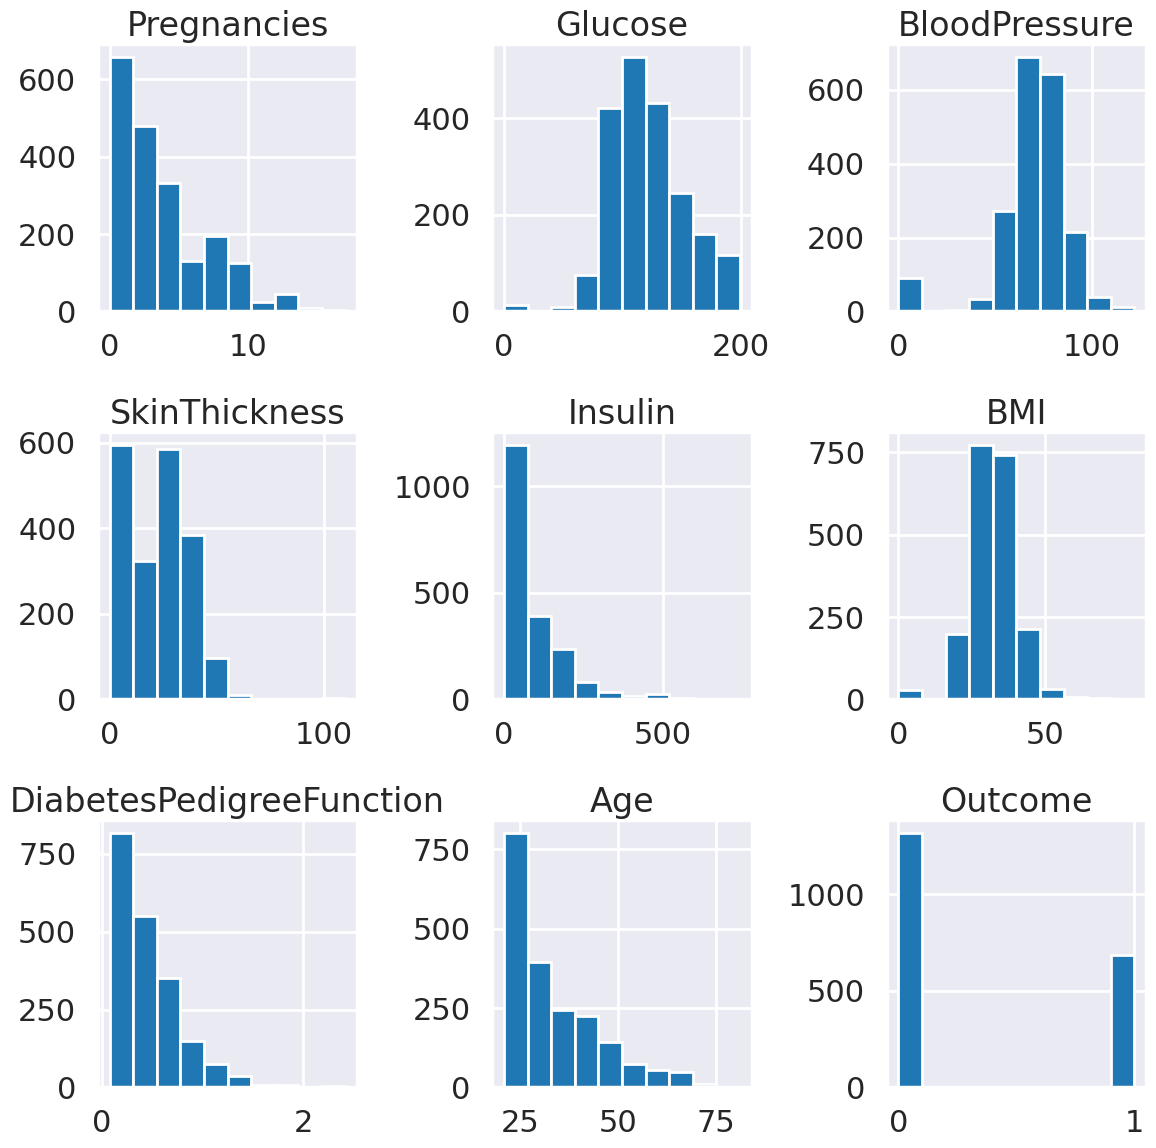

In [11]:
# Генерирует гистограммы для всех числовых столбцов в DataFrame
df.hist(figsize=(12, 12), bins=10)
plt.tight_layout() # Улучшает размещение подграфиков чтобы они не пересекались
plt.show()

In [12]:
# выведем статистические характеристики
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


In [13]:
# выведем матрицу корреляции
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.120405,0.149672,-0.063375,-0.076600,0.019475,-0.025453,0.539457,0.224437
Glucose,0.120405,1.000000,0.138044,0.062368,0.320371,0.226864,0.123243,0.254496,0.458421
BloodPressure,0.149672,0.138044,1.000000,0.198800,0.087384,0.281545,0.051331,0.238375,0.075958
SkinThickness,-0.063375,0.062368,0.198800,1.000000,0.448859,0.393760,0.178299,-0.111034,0.076040
Insulin,-0.076600,0.320371,0.087384,0.448859,1.000000,0.223012,0.192719,-0.085879,0.120924
BMI,0.019475,0.226864,0.281545,0.393760,0.223012,1.000000,0.125719,0.038987,0.276726
DiabetesPedigreeFunction,-0.025453,0.123243,0.051331,0.178299,0.192719,0.125719,1.000000,0.026569,0.155459
Age,0.539457,0.254496,0.238375,-0.111034,-0.085879,0.038987,0.026569,1.000000,0.236509
Outcome,0.224437,0.458421,0.075958,0.076040,0.120924,0.276726,0.155459,0.236509,1.000000


<Axes: >

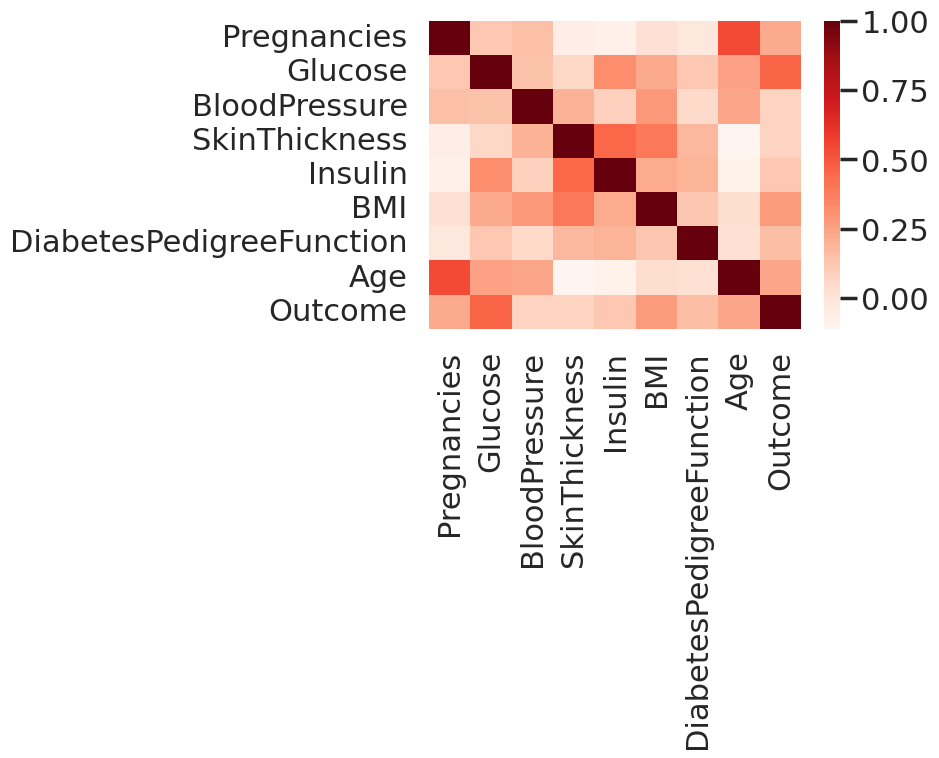

In [14]:
sns.heatmap(df.corr(),cmap='Reds')

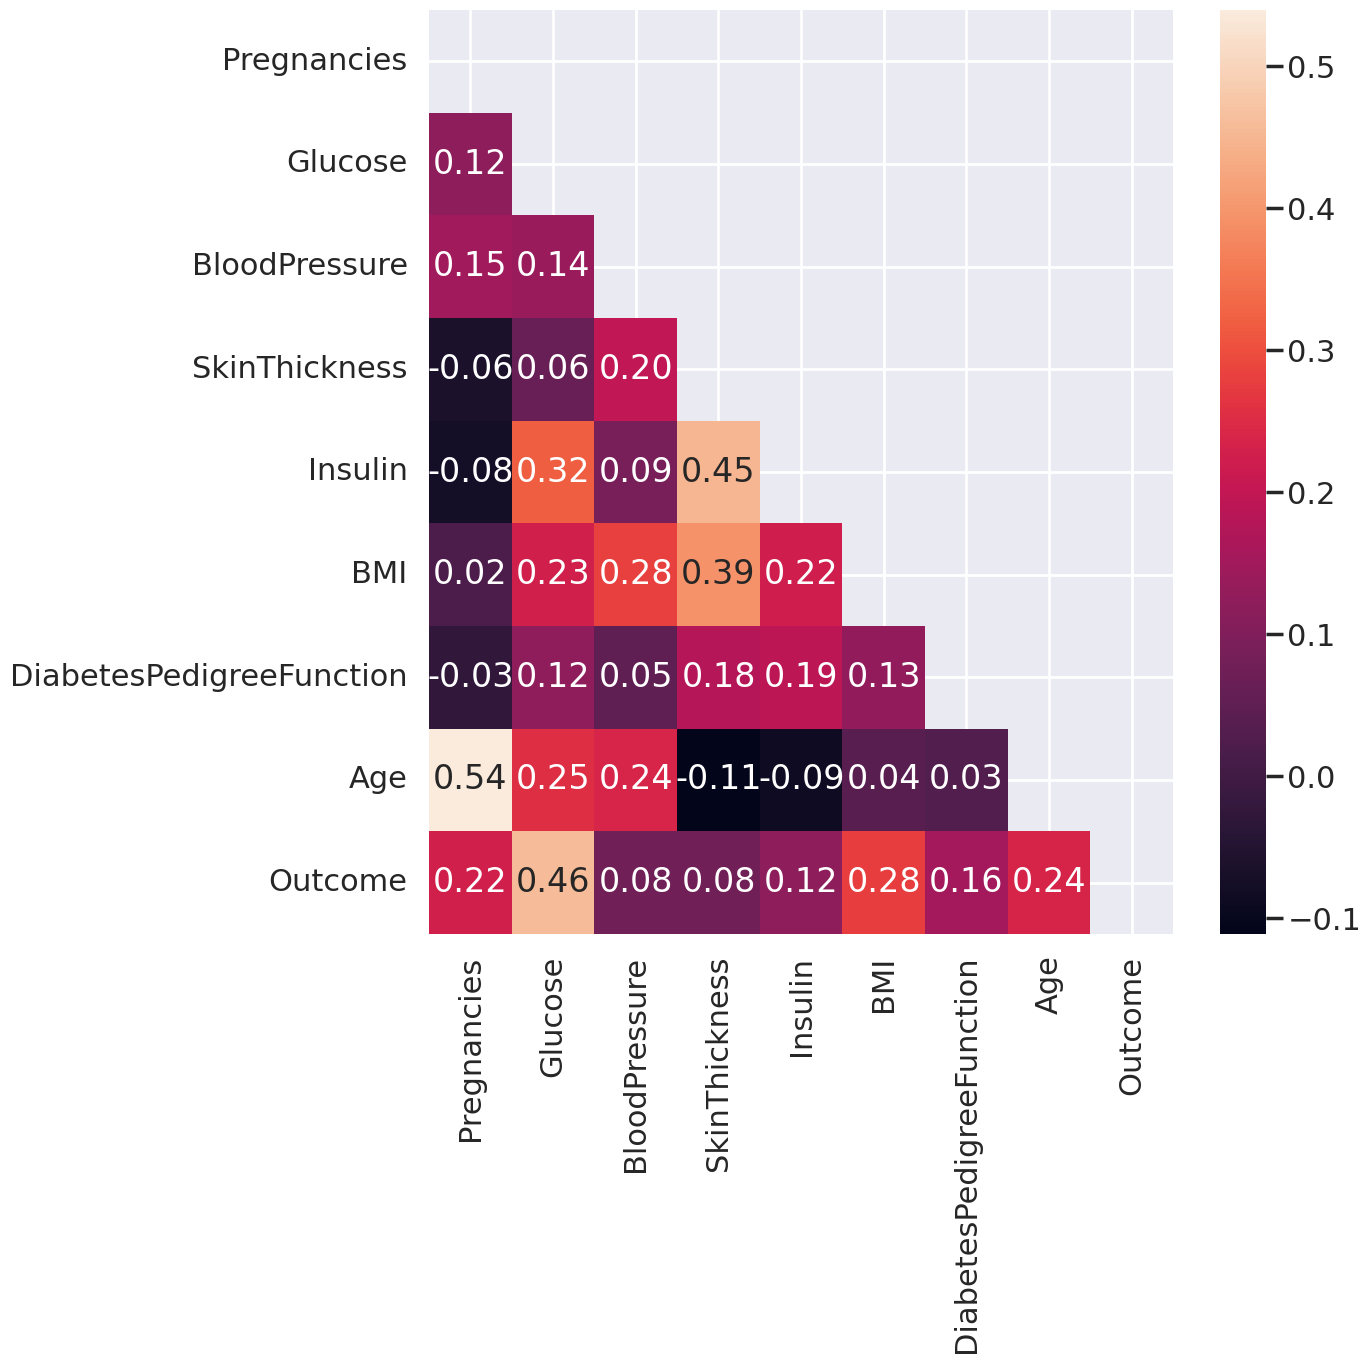

In [15]:
plt.subplots(figsize=(12, 12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), mask=mask, annot = True, fmt = ".2f")
plt.show()

Положительная корреляция 'Outcome' с переменной "Glucose" (0.48): это указывает, что более высокие значения уровня глюкозы в крови ассоциируются с наличием диабета.

Дополнительно для этого набора данных, можно отметить высокую корреляцию переменных 'Age', 'Pregnancies' - 0.54.



In [16]:
# Предварительная обработка данных
scaler = StandardScaler()
X = df.drop('Outcome', axis=1)
X_scaled = scaler.fit_transform(X)
y = df['Outcome']

# Создание и обучение модели логистической регрессии
lg = LogisticRegression()
lg.fit(X_scaled, y)

# После обучения модели можно получить коэффициенты\
lg.coef_

array([[ 0.4153434 ,  1.07535288, -0.18319629,  0.00808396, -0.13573646,
         0.62855868,  0.28566424,  0.15349578]])

In [17]:
feature_names = X.columns
coefficients = lg.coef_[0]  # lg.coef_ возвращает массив в массиве, если модель обучена на двухмерном X

# Связывание имен признаков с их коэффициентами
feature_importances = zip(feature_names, coefficients)

# Преобразование в список для более удобного отображения
feature_importance_list = list(feature_importances)

# Отображение признаков и их коэффициентов
for feature, coef in feature_importance_list:
    print(f"{feature}: {coef}")

Pregnancies: 0.41534340173391643
Glucose: 1.0753528828071826
BloodPressure: -0.18319628687605652
SkinThickness: 0.008083962798492378
Insulin: -0.13573645820722036
BMI: 0.6285586828525688
DiabetesPedigreeFunction: 0.285664238527223
Age: 0.1534957844322139


- Pregnancies (Количество беременностей): 0.4153 - положительный коэффициент, означает, что чем больше беременностей у пациента, тем выше вероятность диабета (хотя значение не очень большое).
- Glucose (Уровень глюкозы): 1.0754 - сообщает, что чем выше уровень глюкозы, тем выше вероятность диабета.
- BloodPressure (Артериальное давление): -0.1832 - отрицательный коэффициент означает, чем выше артериальное давление, тем ниже вероятность диабета (хотя значения не очень большое).
- SkinThickness (Толщина кожи): 0.0081 - очень маленький коэф., что указывает на незначительное влияние этого признака на вероятность диабета.
- Insulin (Уровень инсулина): -0.1357 - отрицательный коэф, показывает, чем выше уровень инсулина, тем ниже вероятность диабета.
- BMI (Индекс массы тела): 0.6286 - чем выше BMI, тем выше вероятность диабета.
- DiabetesPedigreeFunction 0.2857 - чем больше в семейном анамнезе было случаев диабета, тем выше вероятность диабета у текущего пациента.
- Age (Возраст): 0.1535 - чем старше пациент, тем выше вероятность диабета.

Наиболее значимые признаки: Уровень глюкозы (Glucose), BMI и семейный анамнез диабета (DiabetesPedigreeFunction) имеют наиболее сильное влияние на вероятность диабета.

Другие признаки: количество беременностей (Pregnancies), уровень инсулина (Insulin) и возраст (Age) также влияют, но менее значительно.

Артериальное давление (BloodPressure) и толщина кожи (SkinThickness): имеют слабое влияние на вероятность диабета в данной модели.

In [22]:
# Разделим данные на обучающую и тестовую выборки, с учетом наиболее значимых признаков Glucose, BMI и DiabetesPedigreeFunction на вероятность диабета
X = df[['Glucose', 'BMI', 'DiabetesPedigreeFunction']]
y = df['Outcome']

# Разделяем датасет на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Обучающая выборка: {X_train.shape}, {y_train.shape}")
print(f"Тестовая выборка: {X_test.shape}, {y_test.shape}")

Обучающая выборка: (1600, 3), (1600,)
Тестовая выборка: (400, 3), (400,)


In [23]:
# Создадим объект модели логистической регрессии (LogisticRegression).
# class_weight='balanced' - устанавливает балансировку классов. Модель будет уделять больше внимания классам с меньшим количеством данных, чтобы избежать перевеса в сторону доминирующего класса.

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy1)

Accuracy: 0.74


In [31]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       253
           1       0.64      0.68      0.66       147

    accuracy                           0.74       400
   macro avg       0.72      0.73      0.72       400
weighted avg       0.74      0.74      0.74       400



Модель лучше справляется с классом “без диабета”: точность для класса “0” (без диабета) выше, чем для класса “1” (с диабетом).

Необходимо улучшить предсказания для класса “диабет”: Recall и F1-score для класса “1” (с диабетом) ниже, чем для класса “0”. Это означает, что модель не так хорошо предсказывает случаи диабета.

Добавим параметр уровень инсулина (Insulin), он может оказывать влияние на вероятность диабета

In [34]:
X = df[['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Insulin']]
y = df['Outcome']

X_train, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
model1 = LogisticRegression(class_weight='balanced')
model1.fit(X_train, y_train)

predictions1 = model1.predict(X_test1)
accuracy2 = accuracy_score(y_test, predictions1)
print("Accuracy:", accuracy2)

Accuracy: 0.7475


In [32]:
print(classification_report(y_test, predictions1))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       253
           1       0.64      0.72      0.68       147

    accuracy                           0.75       400
   macro avg       0.73      0.74      0.73       400
weighted avg       0.76      0.75      0.75       400



Recall (Полнота) для класса “1” (с диабетом): увеличился с 0.68 до 0.72.
Это означает, что модель стала лучше выявлять случаи диабета среди тех, у кого он действительно есть.
F1-score для класса “1” (с диабетом): также увеличился с 0.66 до 0.68, что показывает улучшение в сбалансированной оценке модели для этого класса.

Precision (Точность) для класса “1” (с диабетом): осталась на уровне 0.64.
Это означает, что из всех предсказанных случаев “диабета” 64% действительно были “диабетами”. Несмотря на то, что recall улучшился, precision остаётся на том же уровне.
Общее улучшение accuracy увеличилась с 0.74 до 0.75, что говорит об общем улучшении модели.

Добавим параметр возраста (Age), он также может оказывать влияние на вероятность диабета (чем старше человек тем выше вероятность)

In [37]:
X = df[['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Insulin', 'Age']]
y = df['Outcome']

X_train, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
model2 = LogisticRegression(class_weight='balanced')
model2.fit(X_train, y_train)

predictions2 = model2.predict(X_test2)
accuracy3 = accuracy_score(y_test, predictions2)
print("Accuracy:", accuracy3)

Accuracy: 0.745


In [39]:
print(classification_report(y_test, predictions2))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       253
           1       0.63      0.74      0.68       147

    accuracy                           0.74       400
   macro avg       0.73      0.74      0.73       400
weighted avg       0.76      0.74      0.75       400



Recall (Полнота) для класса “1” (с диабетом): увеличился с 0.72 до 0.74. Модель стала еще лучше выявлять случаи диабета.
Precision (Точность) для класса “1” (с диабетом): снизился с 0.64 до 0.63. Модель стала менее точной в предсказании “диабета” среди тех, кого она отнесла к этому классу.
Однако, Precision (Точность) для класса “1” (с диабетом) продолжает быть относительно низким.

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
models = {
    'Model 1': model,
    'Model 2': model1,
    'Model 3': model2
}

test_datasets = {
    'Model 1': X_test,
    'Model 2': X_test1,
    'Model 3': X_test2,
}

results = []

for model_name, model in models.items():
    X_test = test_datasets[model_name]
    y_pred = model.predict(X_test)
    scores = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='binary'),
        recall_score(y_test, y_pred, average='binary'),
        f1_score(y_test, y_pred, average='binary')
    ]
    results.append(scores)

# Создаем DataFrame для результатов
results_df = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=models.keys())

In [41]:
results_df

,Accuracy,Precision,Recall,F1
Model 1,0.7400,0.636943,0.680272,0.657895
Model 2,0.7475,0.638554,0.721088,0.677316
Model 3,0.7450,0.630058,0.741497,0.681250


Нет существенных изменений, в данном случае у нас была проблема с дисбалансом классов, accuracy не дает релевантной оценки данной модели

In [48]:
X = df[['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Insulin', 'Age']]
y = df['Outcome']

X_train, X_test3, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Передадим в параметры веса и сравним
model_weight = LogisticRegression(class_weight={0:0.30, 1:0.70})
model_weight.fit(X_train, y_train)

predictions3 = model_weight.predict(X_test3)
accuracy4 = accuracy_score(y_test, predictions3)
print("Accuracy:", accuracy4)

Accuracy: 0.735


In [54]:
models = {
    'Model 3': model2,
    'Model': model_weight,
}

test_datasets = {
    'Model 3': X_test2,
    'Model': X_test3,
}

results = []

for model_name, model in models.items():
    X_test = test_datasets[model_name]
    y_pred = model.predict(X_test)
    scores = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='binary'),
        recall_score(y_test, y_pred, average='binary'),
        f1_score(y_test, y_pred, average='binary')
    ]
    results.append(scores)

# Создаем DataFrame для результатов
results_df = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=models.keys())

In [55]:
results_df

,Accuracy,Precision,Recall,F1
Model 3,0.745,0.630058,0.741497,0.681250
Model,0.735,0.610811,0.768707,0.680723


После использования весов общее качество модели стало чуть хуже:

Accuracy уменьшился до 0.735, модель стала менее точнее.
Precision также уменьшился до 0.610811 до 0.630058. Это значит, что модель стала менее точной в предсказании класса “диабет” среди всех предсказанных случаев “диабета”.
Recall немного повысился до 0.768707 с 0.741497. Это означает, что модель стала более полной в выявлянии случаев диабета среди всех фактических случаев “диабета”.
F1-score остался практически без изменений (0.680723 против 0.681250), что указывает на то, что изменения в precision и recall частично компенсируют друг друга.